# Late Procurement Deliveries – Notebook Workflow

## 1. Import Libraries and Set Variables
- Import `pandas`, `matplotlib`, and `scikit-learn` for data handling, visualization, and machine learning.
- Set Variables for repreducability

## 2. Read Data
- Load Excel files for customers, suppliers, materials, warehouses, and procurement transactions.
- Combine two transaction parts into a single DataFrame using a merge on the `id` column.

## 3. Data Preparation
- Create a new column `late` to indicate if a delivery was late (`requested_date < received_date`).
- Define features for modeling: `quantity` and `price`.
- Drop rows with missing values in these features.

## 4. Decision Tree Modeling
- Initialize a `DecisionTreeClassifier` with a maximum depth of 3.
- Fit the model to the data using the selected features.
- Compute the confusion matrix and scores

## 5. Random Forest Modeling
- Initialize a `RandomForestClassifier` with a maximum depth of 3 and 100 trees.
- Fit the model to the data using the selected features.
- Compute the confusion matrix and scores

## 6. Gradient Boosted Trees Modeling
- Initialize a `GradientBoostingClassifier` with a maximum depth of 3 and 100 trees.
- Fit the model to the data using the selected features.
- Compute the confusion matrix and scores


<br><br>

## 1. Import Libraries

In [154]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,                              
                             f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)


Get the current working directory

In [155]:
os.getcwd()

'/Users/jan/Documents/02_teaching/fau/course_business_analytics_students/teaching_cases/case_3_predicting_late_purchase_orders'

Set variables


In [156]:
random_var=2025

## 2. Read Data

Define a variable to where files are saved on the pc

<h4><span style="color: red;">This needs very like to be adjusted!!!!</span></h4>

In [157]:
path_to_files = '../case_2_bi_report/data'

Get supplier data

In [158]:
supplier = pd.read_excel(f'{path_to_files}/supplier.xlsx')

Get the column names

In [159]:
supplier.columns

Index(['id', 'name', 'group', 'country', 'street', 'house_number', 'city',
       'postal_code', 'email'],
      dtype='object')

Show the first rows of data

In [160]:
supplier.head()

,id,name,group,country,street,house_number,city,postal_code,email
0,1,Beans Inc.,raw material,Mexico,Broadway Ave,150,New York,10012,info@beansinc.com
1,2,Aromatico,raw material,Italy,Kaffeegasse,27,Bremen,28195,kontakt@aromatico.de
2,3,Farmers of Brazil,raw material,Brazil,Rua do Cafe,72,Sao Paulo,04567-000,contact@farmersofbrazil.br
3,4,Fair Trade AG,raw material,Panama,Friedensstra√üe,10,Zuerich,8001,service@fairtradeag.ch
4,5,Handelskontor Hamburg,raw material,Germany,Speicherstra√üe,3,Hamburg,20457,info@handelskontor.de


Add a suffix to remember from excel file data was read

In [161]:
supplier = pd.read_excel(f'{path_to_files}/supplier.xlsx').add_prefix('supplier_')

Get material data

In [162]:
material = pd.read_excel(f'{path_to_files}/material.xlsx').add_prefix('material_')

Get warehouse data

In [163]:
warehouse = pd.read_excel(f'{path_to_files}/warehouse.xlsx').add_prefix('warehouse_')

Get transaction data

In [164]:
transactions_part_a = pd.read_excel(f'{path_to_files}/procurement_transactions_part_A.xlsx')

In [165]:
transactions_part_b = pd.read_excel(f'{path_to_files}/procurement_transactions_part_B.xlsx')

Check output for transactions part_a

In [166]:
transactions_part_a.head()

,supplier_code,material_code,warehouse_code,logistic_partner_code,id
0,14,c_2,2,6,c9e0d7a4-bbb6-400c-b2b2-4ea3ba04060f
1,14,c_2,7,6,cc543547-3253-4ce0-bf8b-247baf882c0a
2,10,c_1,4,6,6283fc26-1d28-4b95-976a-eec6e83c42b5
3,4,c_0,6,6,a7351547-34e6-4c5c-89c8-0062d94f8d3e
4,4,c_0,3,6,e35b104e-a41c-4712-9753-317e18f5c584


## 3. Data Preparation

### Combine transactions together
use a Left-Join to combine both dataframes via the column ID

In [167]:
transactions = pd.merge(transactions_part_a, transactions_part_b, on='id')

In [168]:
transactions.head()

,supplier_code,material_code,warehouse_code,logistic_partner_code,id,order_date,requested_date,received_date,quantity,price
0,14,c_2,2,6,c9e0d7a4-bbb6-400c-b2b2-4ea3ba04060f,2019-06-06,2019-06-16,2019-06-12 02:00:00,750,3.886901
1,14,c_2,7,6,cc543547-3253-4ce0-bf8b-247baf882c0a,2022-12-28,2023-01-09,2023-01-05 00:00:00,750,6.433883
2,10,c_1,4,6,6283fc26-1d28-4b95-976a-eec6e83c42b5,2019-09-08,2019-09-27,2019-09-25 03:00:00,250,4.848504
3,4,c_0,6,6,a7351547-34e6-4c5c-89c8-0062d94f8d3e,2022-03-30,2022-04-17,2022-04-11 02:00:00,500,56.026029
4,4,c_0,3,6,e35b104e-a41c-4712-9753-317e18f5c584,2019-03-30,2019-04-18,2019-04-14 04:00:00,250,23.635190


### Add Supplier Info

In [169]:
transactions = pd.merge(transactions, supplier, left_on='supplier_code', right_on='supplier_id', how='left')

In [170]:
transactions.columns

Index(['supplier_code', 'material_code', 'warehouse_code',
       'logistic_partner_code', 'id', 'order_date', 'requested_date',
       'received_date', 'quantity', 'price', 'supplier_id', 'supplier_name',
       'supplier_group', 'supplier_country', 'supplier_street',
       'supplier_house_number', 'supplier_city', 'supplier_postal_code',
       'supplier_email'],
      dtype='object')

### Calculate whether a delivery was late

In [171]:
transactions['late'] = transactions['requested_date'] < transactions['received_date']

#### Check Supplier

In [172]:
transactions.groupby('supplier_name')['late'].mean().sort_values(ascending=False)

supplier_name
The Bean Curators           0.993103
Origin Lineage Trading      0.933121
Green Bean Collective       0.736156
RoastWorks Supply Co.       0.582857
Equator Supply Network      0.578947
Humble Roots Trading Co.    0.568254
Farmers of Brazil           0.564470
Small Batch Supply          0.557632
Handelskontor Hamburg       0.361971
Aromatico                   0.356507
Craft Roast Co-Op           0.350678
Beans Inc.                  0.350027
Grindline Partners          0.349147
TerraBean Source Co.        0.348135
Fair Trade AG               0.340690
Name: late, dtype: float64

get column names of transactions

In [173]:
transactions.columns

Index(['supplier_code', 'material_code', 'warehouse_code',
       'logistic_partner_code', 'id', 'order_date', 'requested_date',
       'received_date', 'quantity', 'price', 'supplier_id', 'supplier_name',
       'supplier_group', 'supplier_country', 'supplier_street',
       'supplier_house_number', 'supplier_city', 'supplier_postal_code',
       'supplier_email', 'late'],
      dtype='object')

### Create Dummy Variables

In [174]:
transactions_with_dummies = pd.get_dummies(transactions, columns=['supplier_code', 'material_code', 'warehouse_code'])

#### Define the features (x-Variables)

In [175]:

features = (['quantity', 'price'] + 
            [col for col in transactions_with_dummies.columns if col.startswith('supplier_code_')] +
            [col for col in transactions_with_dummies.columns if col.startswith('material_code_')] + 
            [col for col in transactions_with_dummies.columns if col.startswith('warehouse_code_')]            
            )

In [176]:
features

['quantity',
 'price',
 'supplier_code_1',
 'supplier_code_2',
 'supplier_code_3',
 'supplier_code_4',
 'supplier_code_5',
 'supplier_code_6',
 'supplier_code_7',
 'supplier_code_8',
 'supplier_code_9',
 'supplier_code_10',
 'supplier_code_11',
 'supplier_code_12',
 'supplier_code_13',
 'supplier_code_14',
 'supplier_code_15',
 'material_code_c_0',
 'material_code_c_1',
 'material_code_c_2',
 'material_code_c_3',
 'material_code_c_4',
 'material_code_c_5',
 'material_code_c_6',
 'material_code_c_7',
 'warehouse_code_1',
 'warehouse_code_2',
 'warehouse_code_3',
 'warehouse_code_4',
 'warehouse_code_5',
 'warehouse_code_6',
 'warehouse_code_7']

#### Clean Data for missing values

In [177]:
transactions_with_dummies.dropna(subset=features, inplace=True)

### Test / Train split


In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    transactions_with_dummies[features], 
    transactions_with_dummies['late'],
    test_size=0.2, 
    random_state=random_var
)

### 4. Decision Tree Modeling

#### Initialize a decision tree with a maximum of 3-levels

In [179]:
tree = DecisionTreeClassifier(max_depth=3, random_state=random_var)


#### 
Fit tree on the data

In [180]:
tree.fit(X=X_train, y=y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2025
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Visualize the decision tree


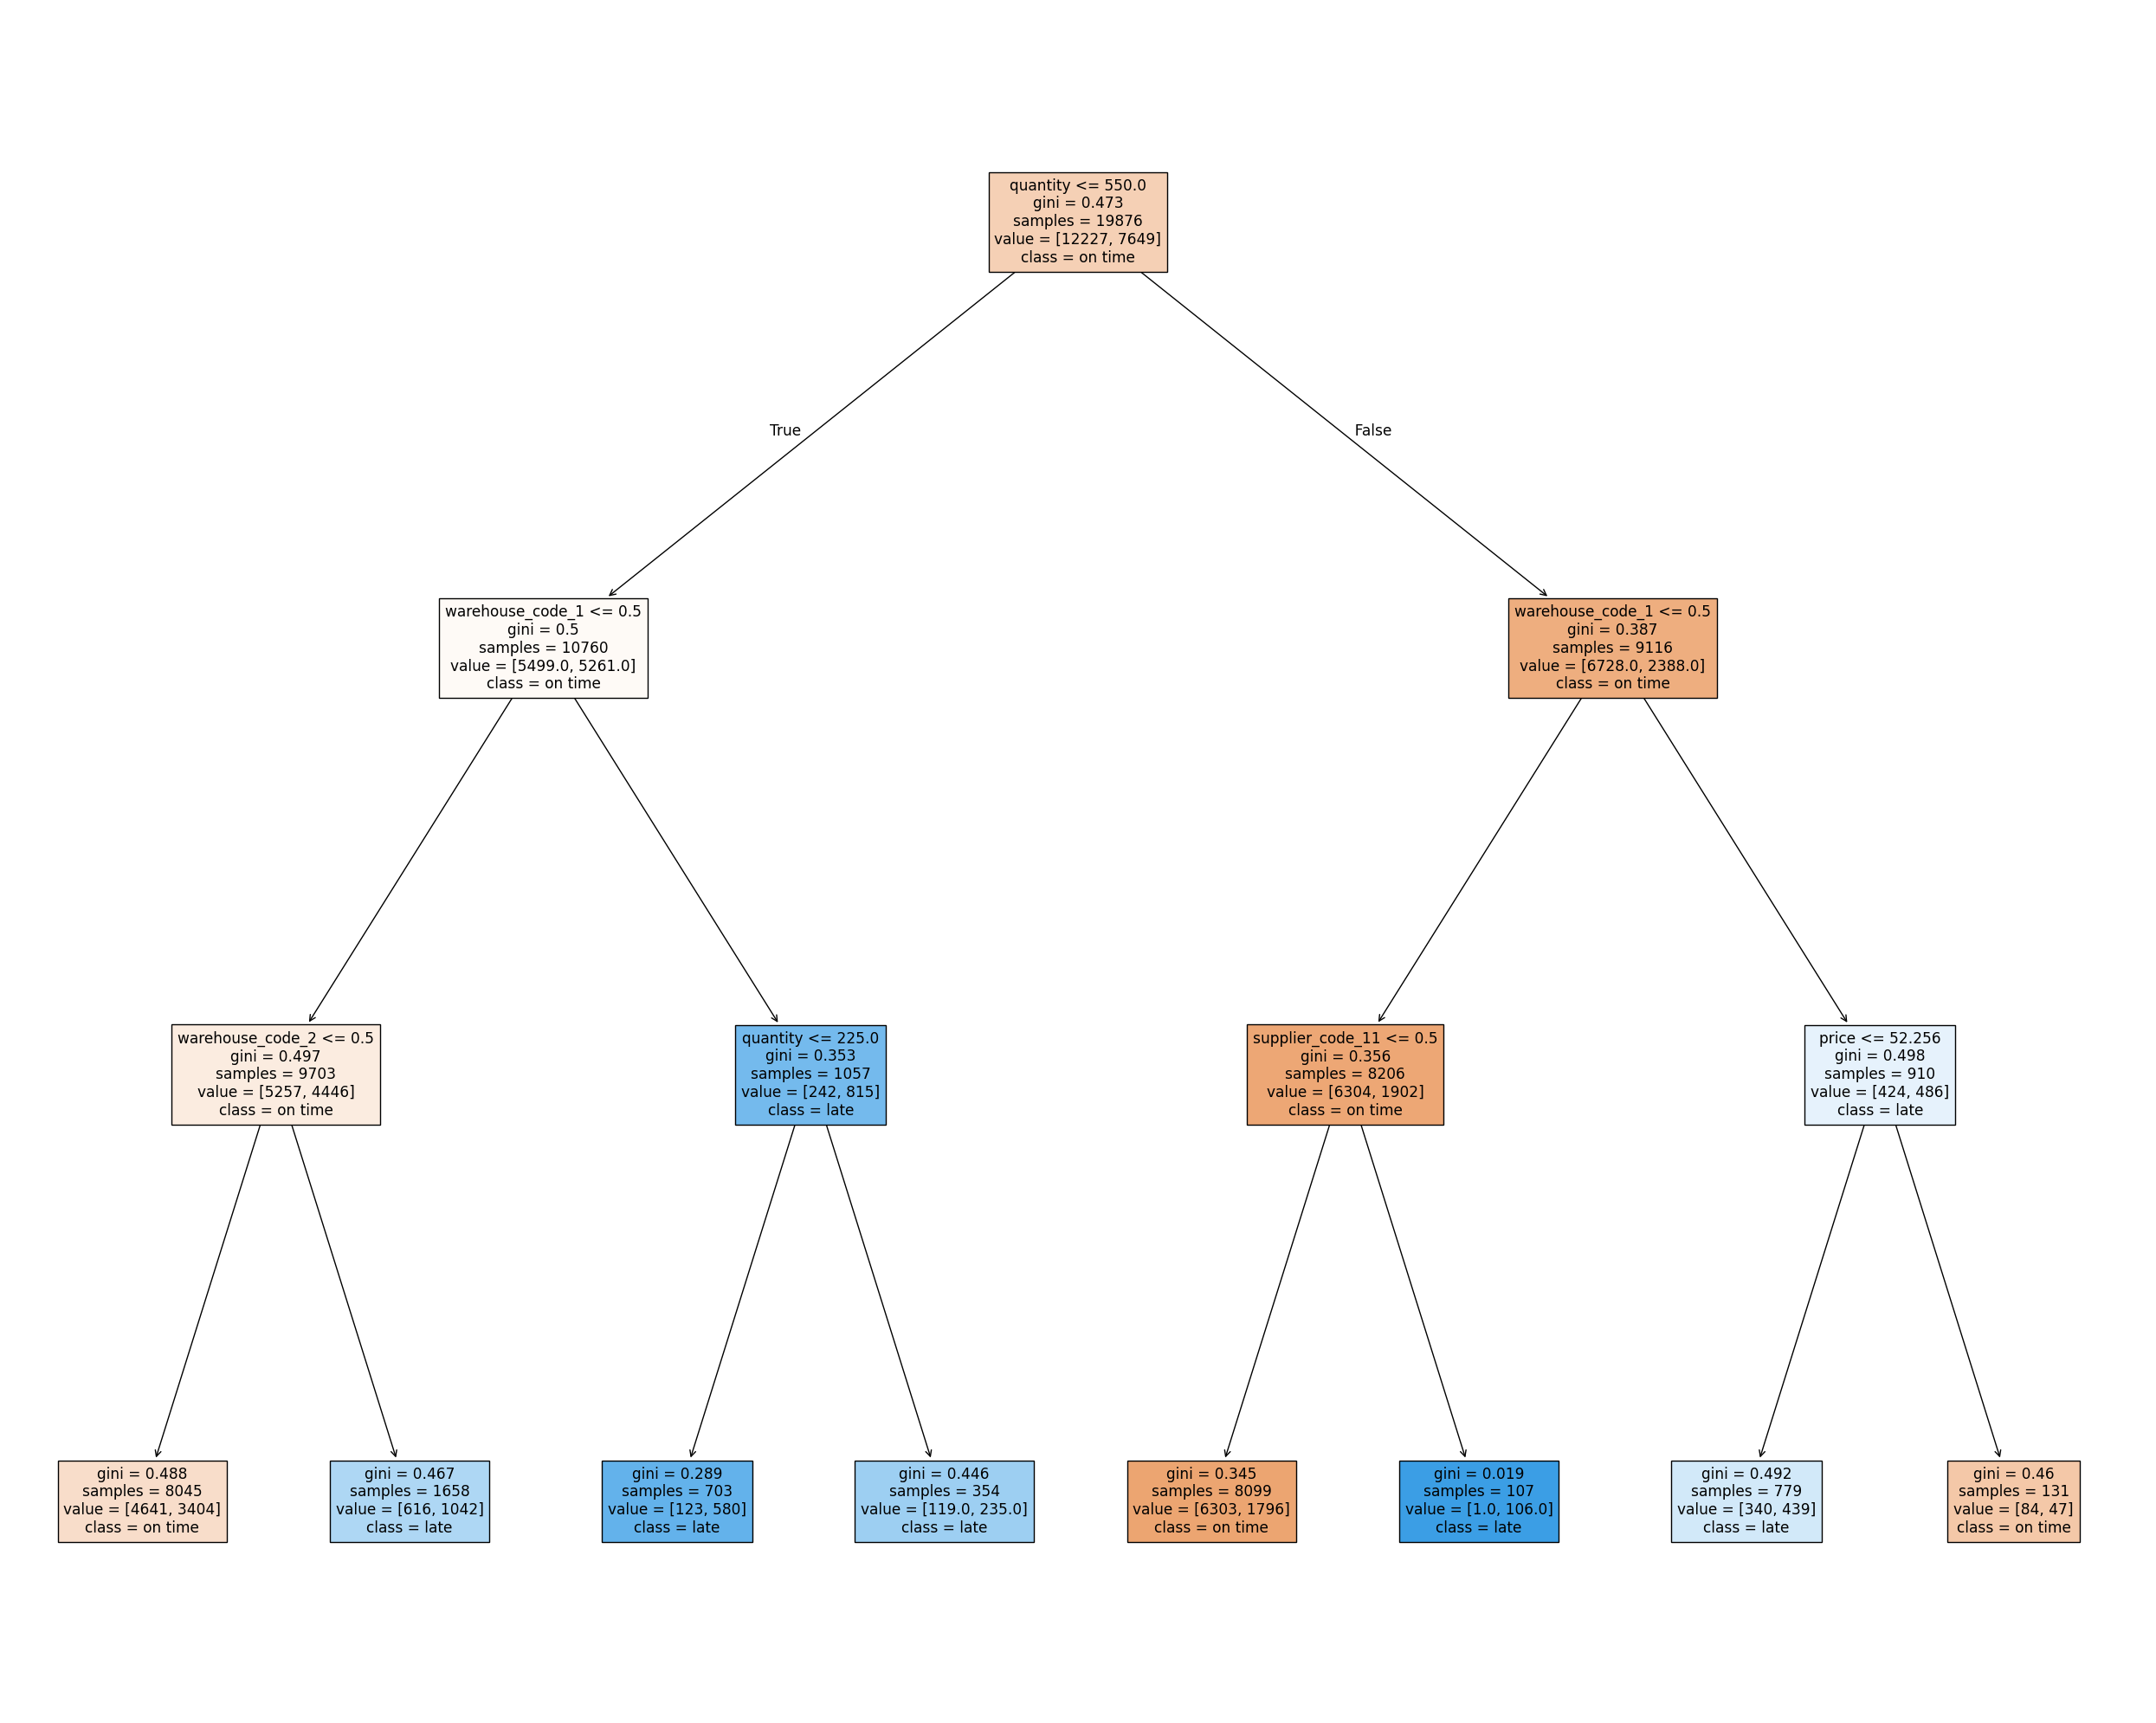

In [181]:
plt.figure(figsize=(25, 20))
plot_tree(
        tree, feature_names=features, 
        class_names=['on time', 'late'], 
        filled=True
        )
plt.tight_layout()
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Model Evaluation

### Get Accuracy of the decision tree

In [182]:
# Calculate predictions for test and train sets
y_pred_test = tree.predict(X_test)
y_pred_train = tree.predict(X_train)



get the confusion matrix for the test dataset

In [183]:
cm = confusion_matrix(y_test, y_pred_test)

Transpose the confusion matrix to invert the axes (same order as in lecture notes)

In [184]:
cm_transposed = cm.T

Display the confusion matrix

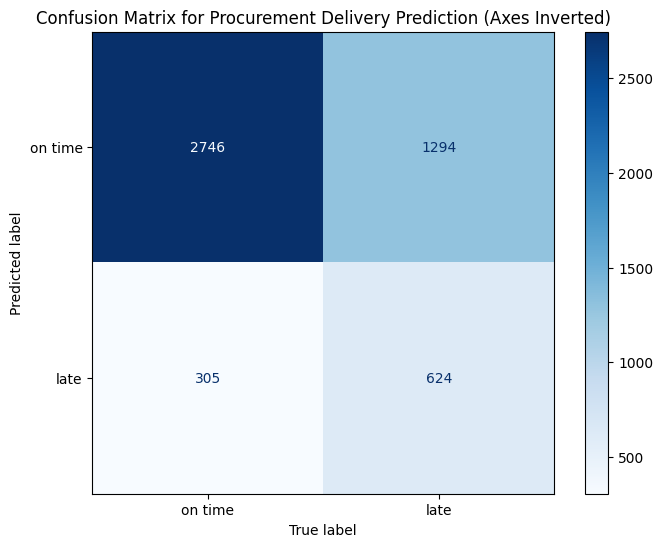

In [185]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.show()

Accuracy: What percentage of the model's predictions were correct?

In [186]:
accuracy_score(y_true=y_test, y_pred=y_pred_test)

0.6782048701952103

Precision: Out of all the positive predictions (delivery is late), how many were actually correct?


In [187]:
precision_score(y_true=y_test, y_pred=y_pred_test)

0.6716899892357373

Recall: Of all the actual positive instances, how many did the model correctly identify? 


In [188]:
recall_score(y_true=y_test, y_pred=y_pred_test)

0.32533889468196037

Calculate Specificity: Of all the actual negative instances (delivery is on time), how many did the model correctly identify?


In [189]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)


In [190]:
specificity

np.float64(0.9000327761389708)

Beautified Output

In [191]:
print(f"Specificity: {specificity:.2f}")

Specificity: 0.90


F-1 Score

In [192]:
f1_score(y_true=y_test, y_pred=y_pred_test)

0.4383561643835616

## Generate overfited tree

In [193]:
tree_overfitted = DecisionTreeClassifier(max_depth=40, random_state=random_var)

In [194]:
tree_overfitted.fit(X=X_train, y=y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,40
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2025
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [195]:
# Calculate predictions for test and train sets
y_pred_test = tree_overfitted.predict(X_test)
y_pred_train = tree_overfitted.predict(X_train)

In [196]:
accuracy_score(y_true=y_test, y_pred=y_pred_test)

0.6488227007446167

In [197]:
accuracy_score(y_true=y_train, y_pred=y_pred_train)

0.9909941638156571

#### Simulate overfitting for different depths

In [198]:
for i in range(3, 30):
    tree_overfitted = DecisionTreeClassifier(max_depth=i, random_state=random_var)
    tree_overfitted.fit(X=X_train, y=y_train)
    
    y_pred_test = tree_overfitted.predict(X_test)
    y_pred_train = tree_overfitted.predict(X_train)
    
    print(f"Max depth: {i}, Test accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_test):.2f}, Train accuracy: {accuracy_score(y_true=y_train, y_pred=y_pred_train):.2f}")

Max depth: 3, Test accuracy: 0.68, Train accuracy: 0.68
Max depth: 4, Test accuracy: 0.68, Train accuracy: 0.68
Max depth: 5, Test accuracy: 0.68, Train accuracy: 0.69
Max depth: 6, Test accuracy: 0.68, Train accuracy: 0.70
Max depth: 7, Test accuracy: 0.68, Train accuracy: 0.70
Max depth: 8, Test accuracy: 0.69, Train accuracy: 0.71
Max depth: 9, Test accuracy: 0.69, Train accuracy: 0.72
Max depth: 10, Test accuracy: 0.70, Train accuracy: 0.73
Max depth: 11, Test accuracy: 0.70, Train accuracy: 0.74
Max depth: 12, Test accuracy: 0.70, Train accuracy: 0.75
Max depth: 13, Test accuracy: 0.70, Train accuracy: 0.76
Max depth: 14, Test accuracy: 0.70, Train accuracy: 0.77
Max depth: 15, Test accuracy: 0.70, Train accuracy: 0.78
Max depth: 16, Test accuracy: 0.68, Train accuracy: 0.80
Max depth: 17, Test accuracy: 0.68, Train accuracy: 0.81
Max depth: 18, Test accuracy: 0.68, Train accuracy: 0.82
Max depth: 19, Test accuracy: 0.68, Train accuracy: 0.84
Max depth: 20, Test accuracy: 0.67, Tr

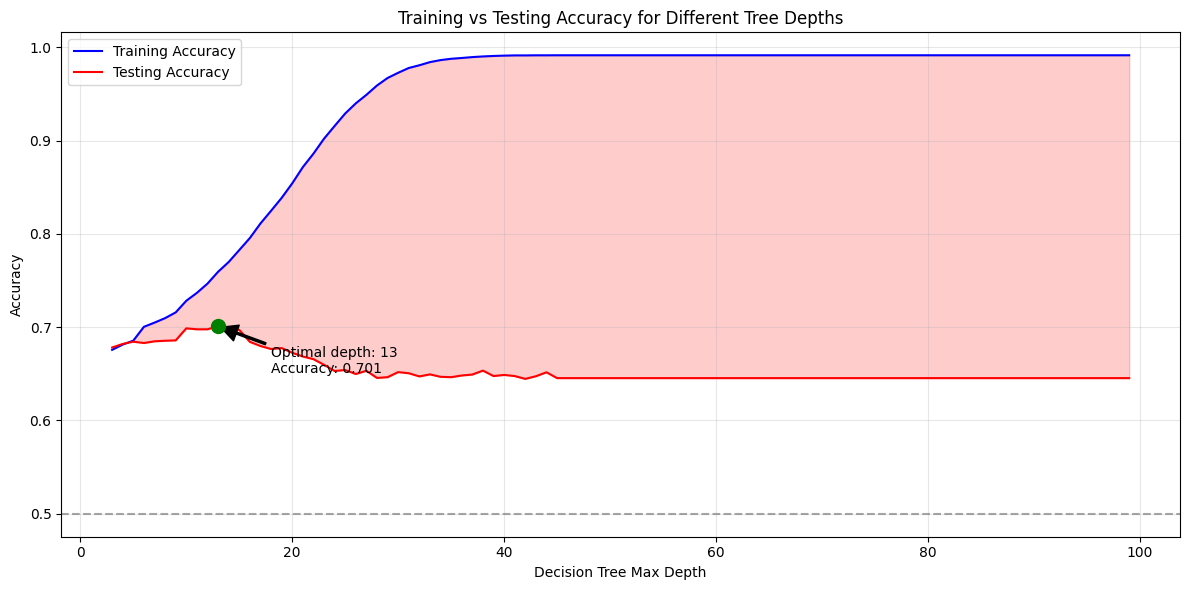

In [ ]:

# Lists to store accuracies
depths = list(range(3, 100))
train_accuracies = []
test_accuracies = []

# Loop over different max depths
for i in depths:
    tree_model = DecisionTreeClassifier(max_depth=i, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(depths, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_depth_index = np.argmax(test_accuracies)
optimal_depth = depths[optimal_depth_index]
optimal_accuracy = test_accuracies[optimal_depth_index]

plt.scatter(optimal_depth, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal depth: {optimal_depth}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_depth, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(depths, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig('tree_depth_accuracy_comparison.png', dpi=300)
plt.show()

## 5. Random Forest

In [200]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=random_var)

In [201]:
rf.fit(X=X_train, y=y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Plot the first 3 trees in the random forest

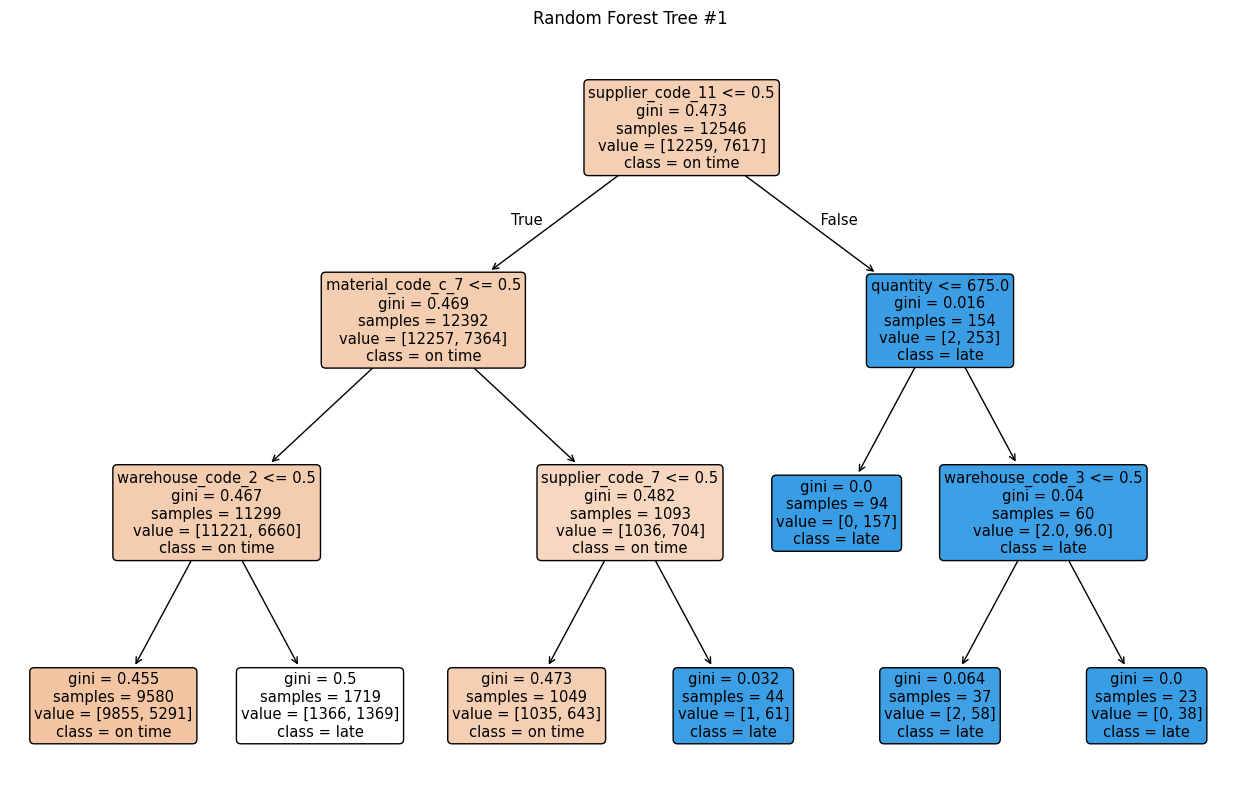

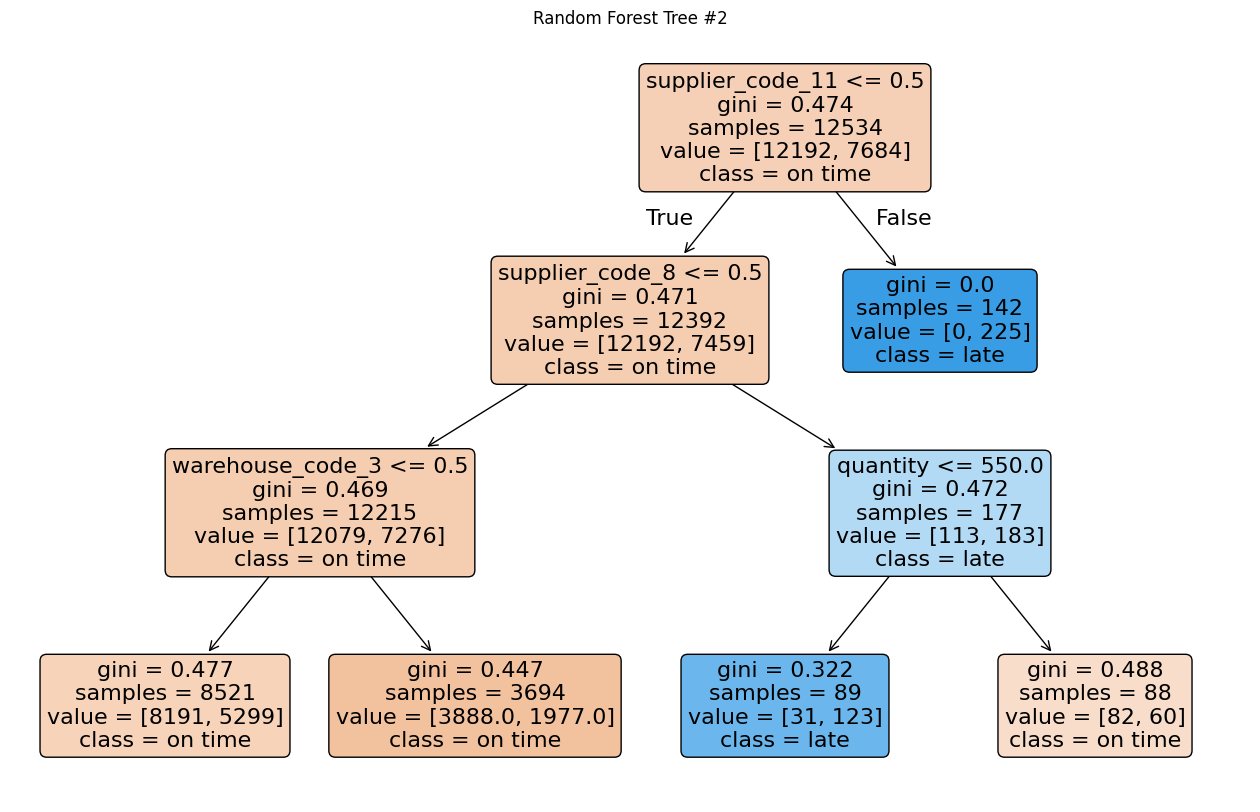

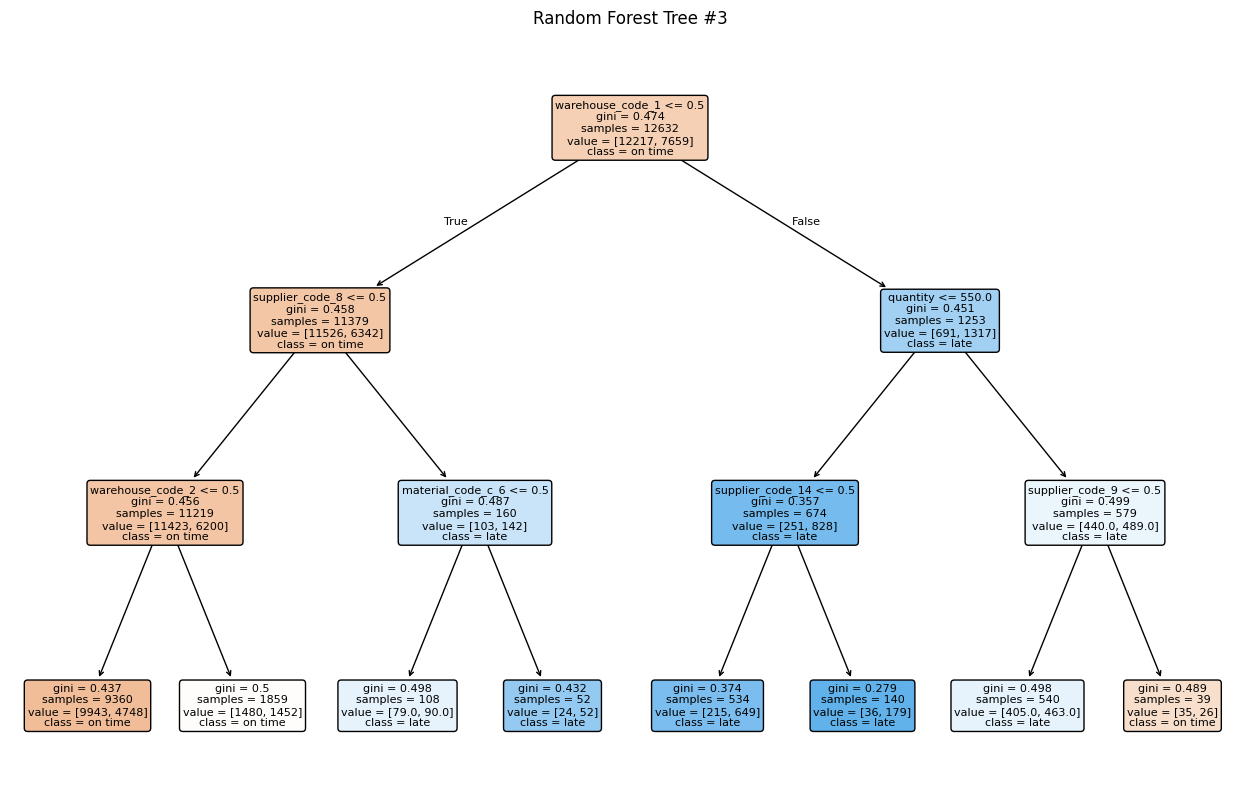

In [202]:

for i in range(3):
    plt.figure(figsize=(16, 10))
    plot_tree(
        rf.estimators_[i],
        feature_names=features,
        class_names=['on time', 'late'],
        filled=True,
        rounded=True,
        max_depth=3  # Optional: limit depth for readability
    )
    plt.title(f"Random Forest Tree #{i+1}")
    plt.show()

In [203]:
rf_pred = rf.predict(X_test)


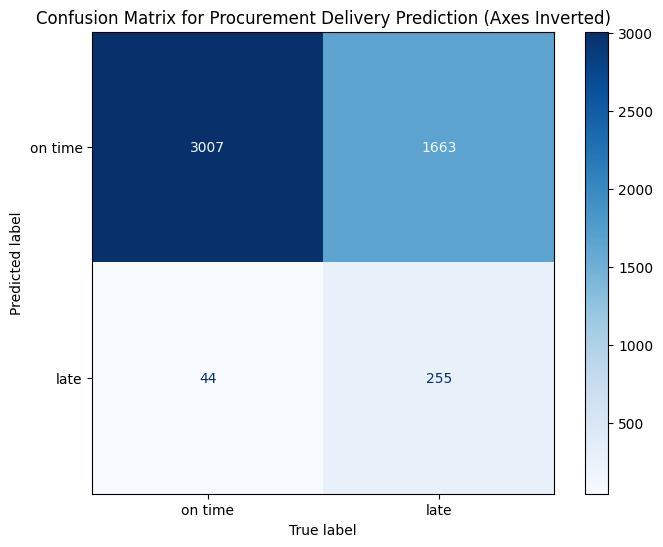

In [204]:
cm = confusion_matrix(y_test, rf_pred)
cm_transposed = cm.T
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.show()

In [205]:
accuracy_score(y_true=y_test, y_pred=rf_pred)

0.6564701147112095

In [206]:
precision_score(y_true=y_test, y_pred=rf_pred)

0.8528428093645485

In [207]:
recall_score(y_true=y_test, y_pred=rf_pred)

0.1329509906152242

### Overfitting with random forest

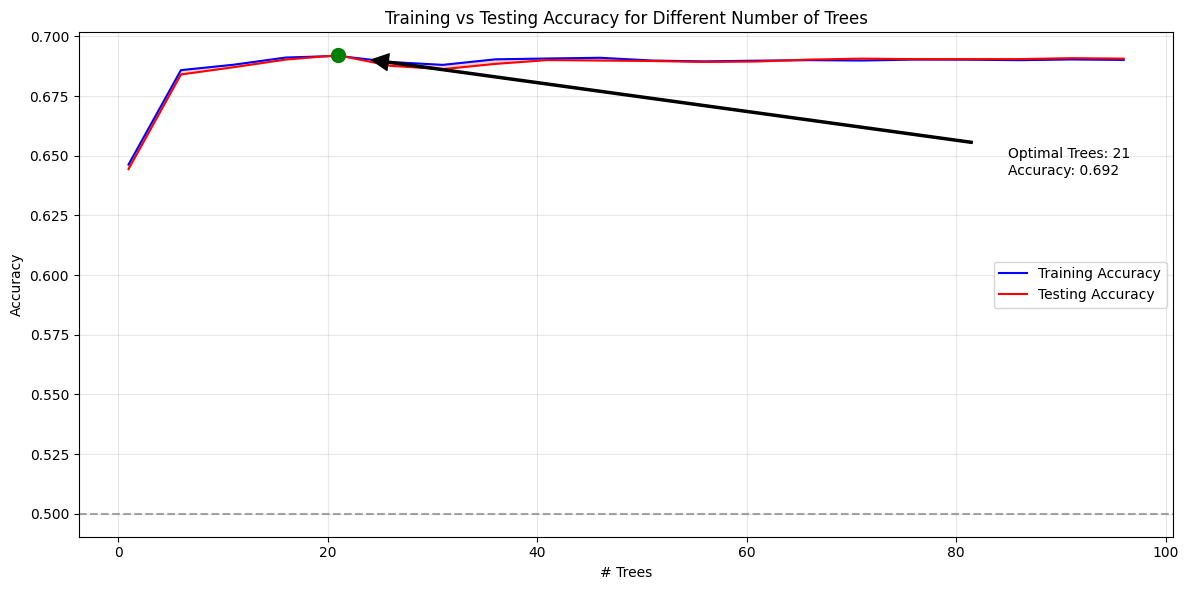

In [235]:

# Lists to store accuracies
trees = list(range(1, 101, 5))
train_accuracies = []
test_accuracies = []

# Loop over different max depths
for i in trees:
    tree_model = RandomForestClassifier(max_depth=5, n_estimators=i, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(trees, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(trees, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('# Trees')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_tree_index = np.argmax(test_accuracies)
optimal_tree = trees[optimal_tree_index]
optimal_accuracy = test_accuracies[optimal_tree_index]

plt.scatter(optimal_tree, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal Trees: {optimal_tree}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_tree, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(trees, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig('gbm_accuracy_comparison.png', dpi=300)
plt.show()

## 6. Gradient Boosted Trees

In [209]:
gbm = GradientBoostingClassifier(n_estimators=20, max_depth=5, random_state=random_var)

In [210]:
gbm.fit(X=X_train, y=y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,20
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [215]:
gbm_pred = gbm.predict(X_test)

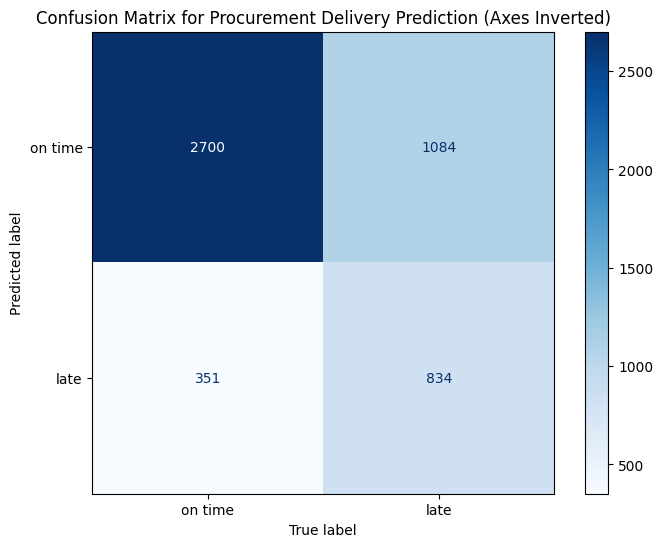

In [216]:
cm = confusion_matrix(y_test, gbm_pred)
cm_transposed = cm.T
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.show()

In [218]:
accuracy_score(y_true=y_test, y_pred=gbm_pred)


0.7112094988931374

In [219]:
precision_score(y_true=y_test, y_pred=gbm_pred)

0.7037974683544304

In [220]:
recall_score(y_true=y_test, y_pred=gbm_pred)

0.4348279457768509

In [ ]:

# Lists to store accuracies
trees = list(range(10, 201, 20))
train_accuracies = []
test_accuracies = []

# Loop over different max depths
for i in trees:
    tree_model = GradientBoostingClassifier(max_depth=5, n_estimators=i, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(trees, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(trees, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('# Trees')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_tree_index = np.argmax(test_accuracies)
optimal_tree = trees[optimal_tree_index]
optimal_accuracy = test_accuracies[optimal_tree_index]

plt.scatter(optimal_tree, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal Trees: {optimal_tree}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_tree, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(trees, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig('gbm_accuracy_comparison.png', dpi=300)
plt.show()